# Problem Statement: For someone with certain Dietary restrictions, which cuisines could be recommended to them?

### Step 1 : Data Preparation and Cleaning

In [1]:
# Import all the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
# Load and read the JSON train data file
cookingData = pd.read_json("../data/train.json")

In [3]:
# Overview of the current cookingData
cookingData.head(10)

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
5,6602,jamaican,"[plain flour, sugar, butter, eggs, fresh ginge..."
6,42779,spanish,"[olive oil, salt, medium shrimp, pepper, garli..."
7,3735,italian,"[sugar, pistachio nuts, white almond bark, flo..."
8,16903,mexican,"[olive oil, purple onion, fresh pineapple, por..."
9,12734,italian,"[chopped tomatoes, fresh basil, garlic, extra-..."


In [4]:
cookingData.tail(10)

,id,cuisine,ingredients
39764,8089,mexican,"[chili powder, worcestershire sauce, celery, r..."
39765,6153,indian,"[coconut, unsweetened coconut milk, mint leave..."
39766,25557,irish,"[rutabaga, ham, thick-cut bacon, potatoes, fre..."
39767,24348,italian,"[low-fat sour cream, grated parmesan cheese, s..."
39768,7377,mexican,"[shredded cheddar cheese, crushed cheese crack..."
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli..."
39773,2362,mexican,"[green chile, jalapeno chilies, onions, ground..."


In [5]:
cookingData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [6]:
#Checking the dimension of test dataframe
cookingData.shape

(39774, 3)

In [7]:
null = cookingData.isna().sum()
null

id             0
cuisine        0
ingredients    0
dtype: int64

In [8]:
# Convert lists to tuples in the 'ingredients' column
cookingData['ingredients'] = cookingData['ingredients'].apply(tuple)

# Drop duplicates
cookingData = cookingData.drop_duplicates()

# If needed, convert tuples back to lists
cookingData['ingredients'] = cookingData['ingredients'].apply(list)

In [9]:
cookingData.drop("id",axis=1)

,cuisine,ingredients
0,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,"[water, vegetable oil, wheat, salt]"
4,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...
39769,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,chinese,"[boneless chicken skinless thigh, minced garli..."


### Step 2 : Basic Exploration

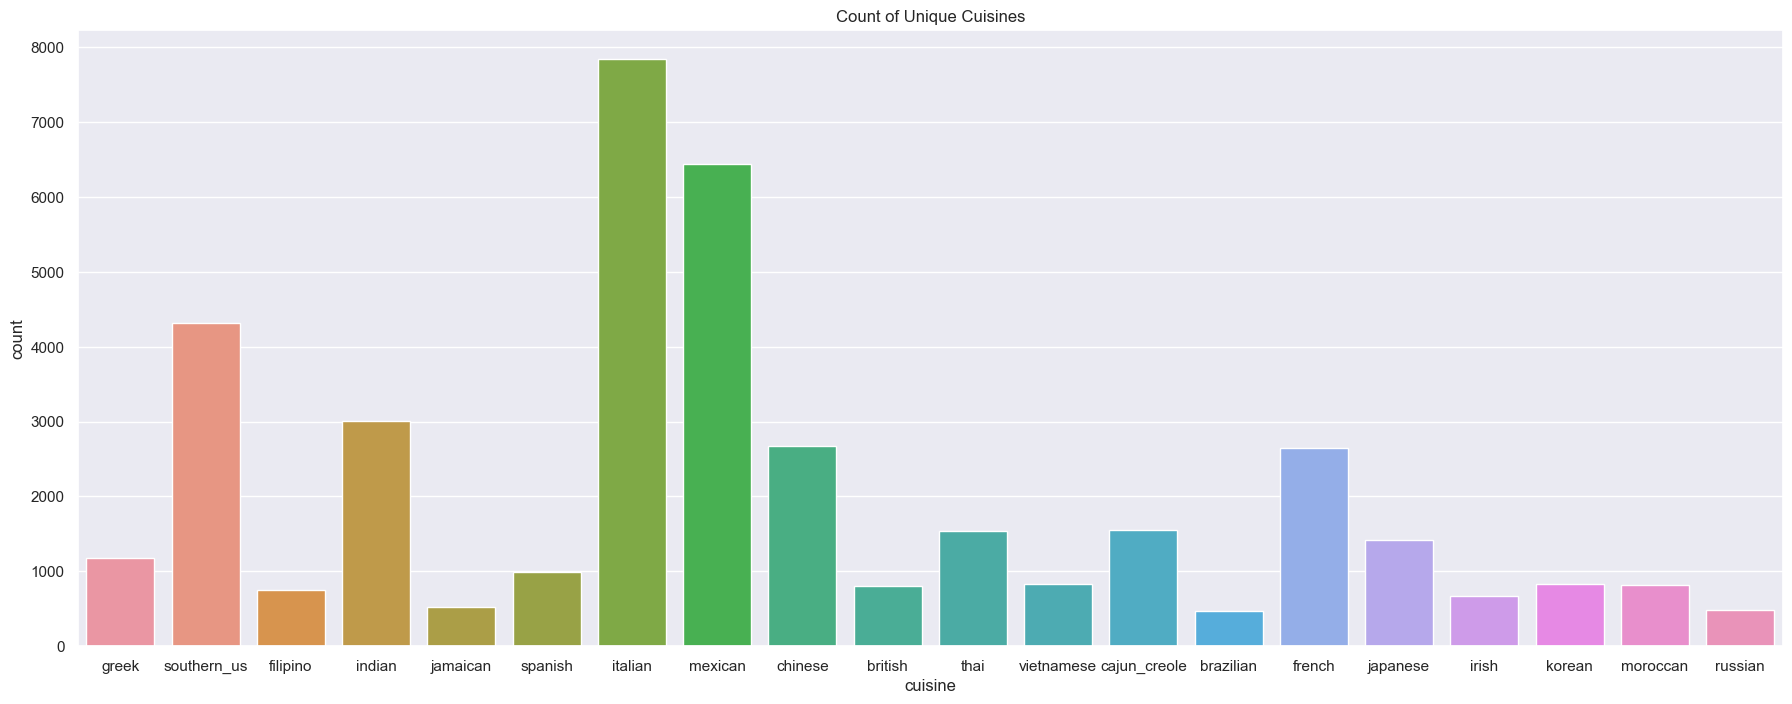

In [10]:
# Univariate Analysis (Catplot) - Cuisine

plt.figure(figsize=(22,8))
plt.title('Count of Unique Cuisines')
ax = sb.countplot(data = cookingData,x = 'cuisine')

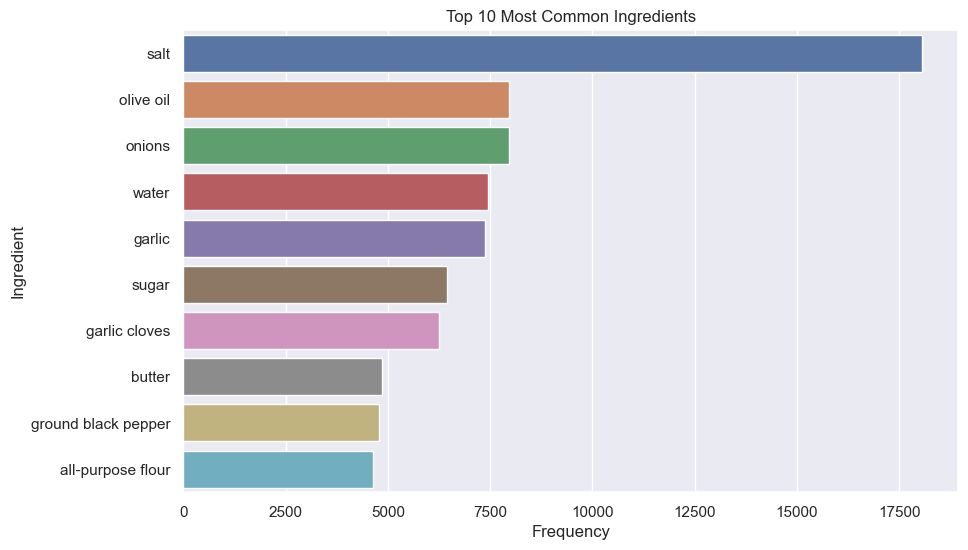

In [11]:
# Visualization 2: Ingredient Frequency
# Flatten the list of ingredients and create a DataFrame with ingredient frequencies
ingredients = [ingredient for ingredients in cookingData['ingredients'] for ingredient in ingredients]
ingredient_df = pd.Series(ingredients).value_counts().reset_index()
ingredient_df.columns = ['Ingredient', 'Frequency']

plt.figure(figsize=(10, 6))
sb.barplot(data=ingredient_df.head(10), x='Frequency', y='Ingredient')
plt.title('Top 10 Most Common Ingredients')
plt.xlabel('Frequency')
plt.ylabel('Ingredient')
plt.show()

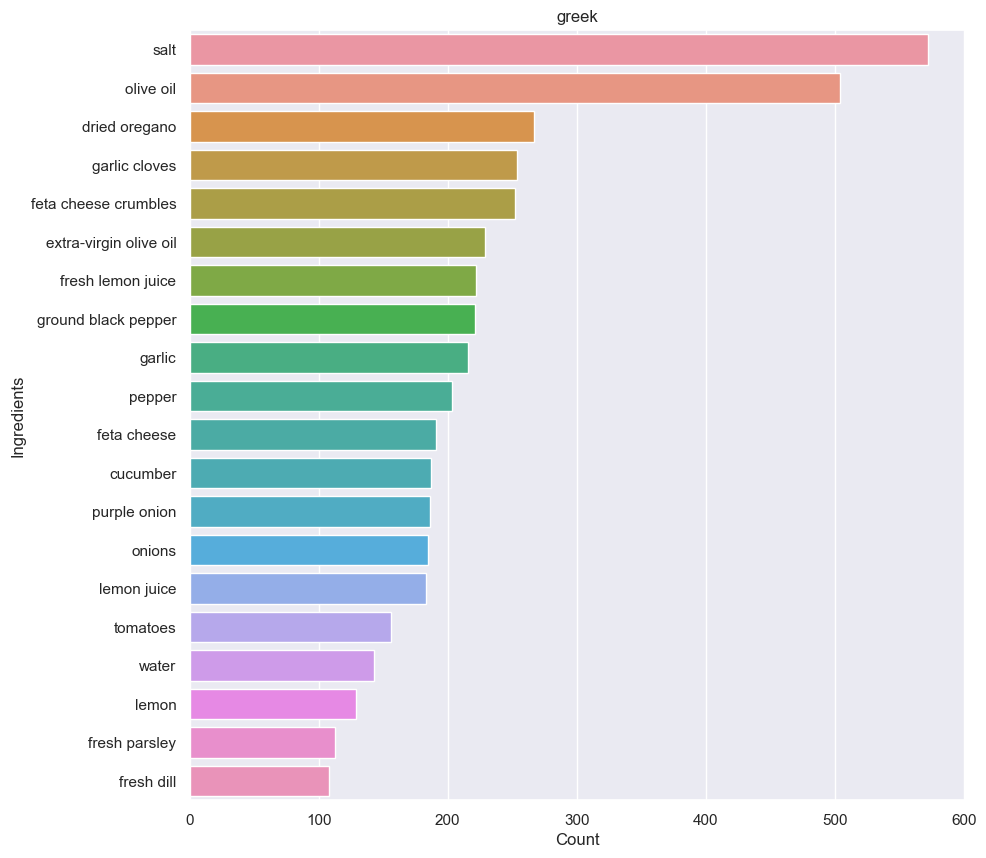

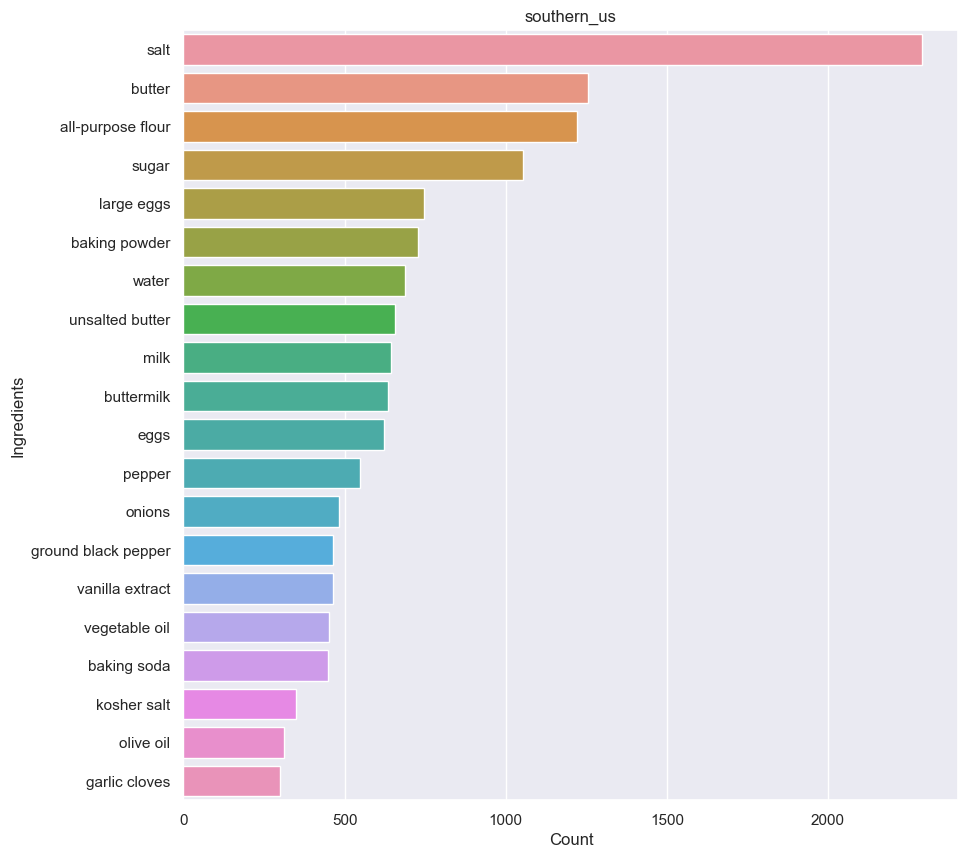

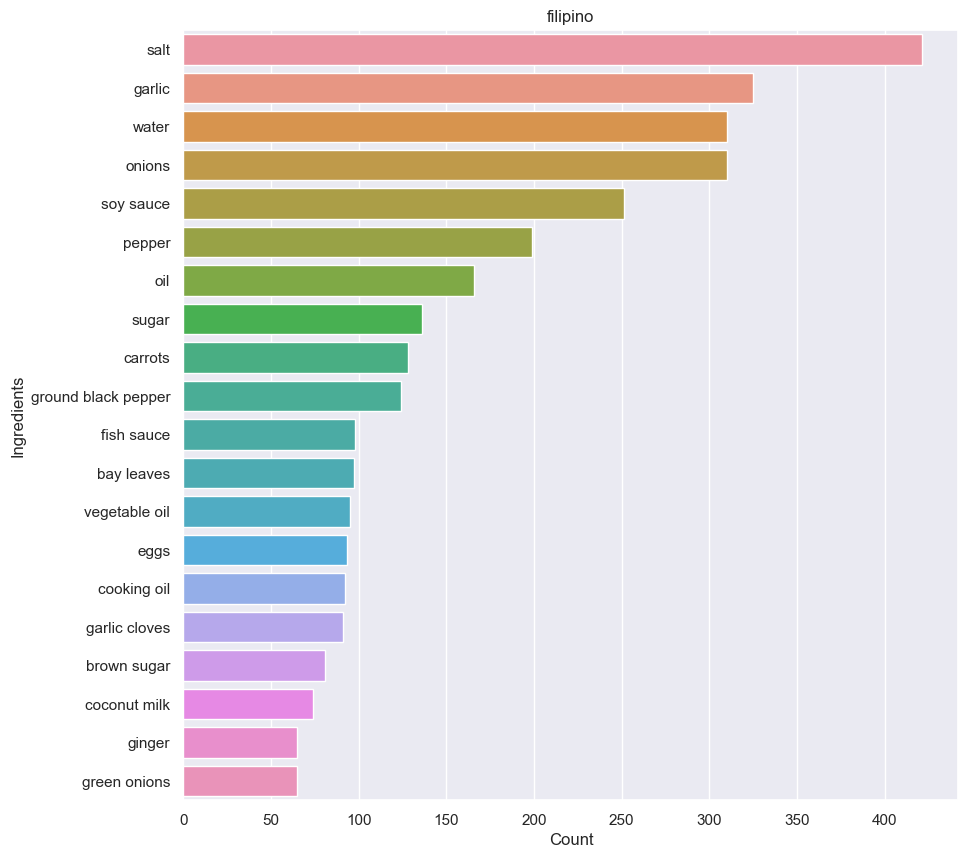

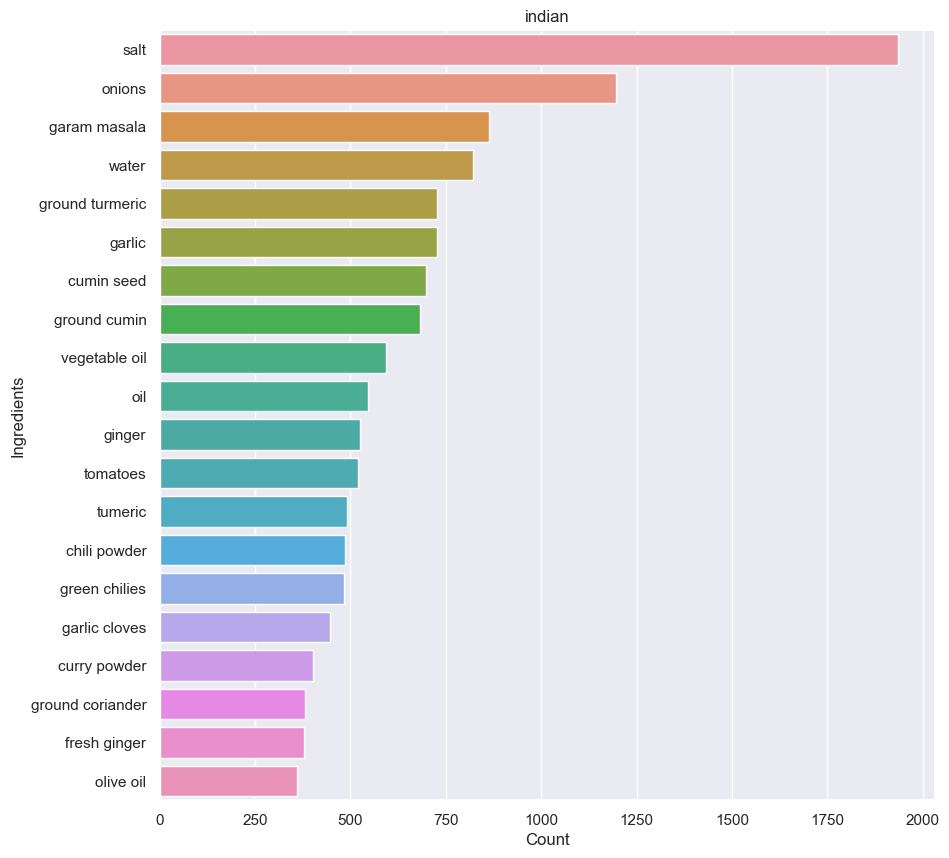

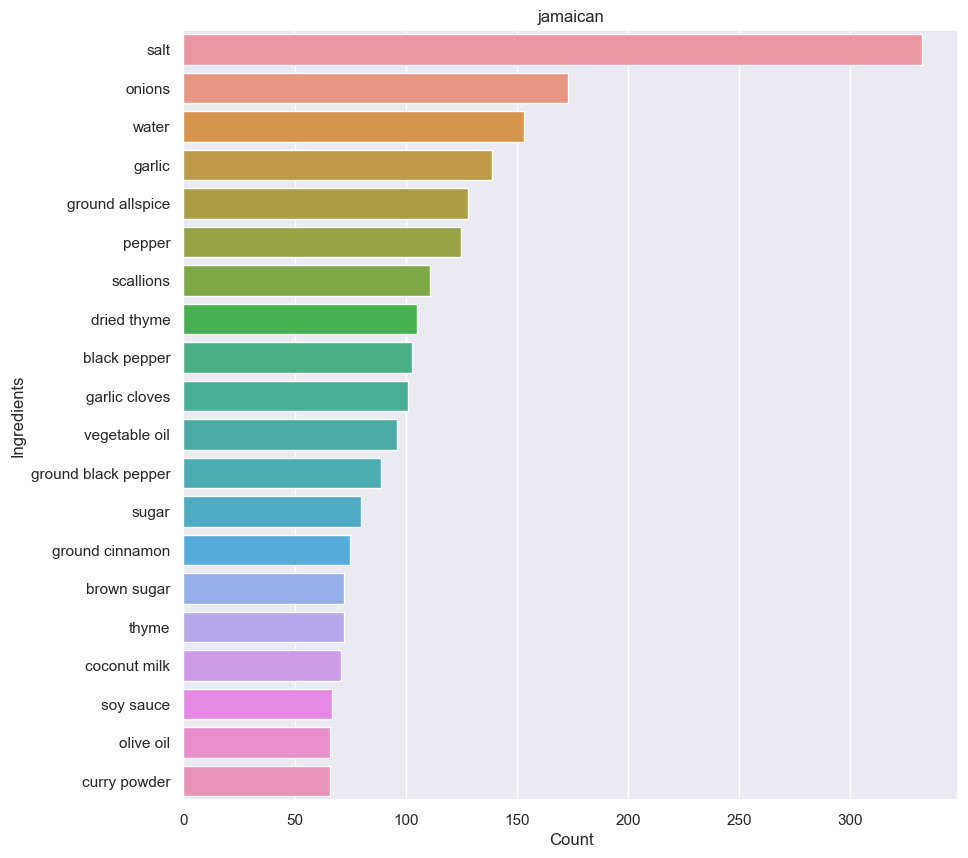

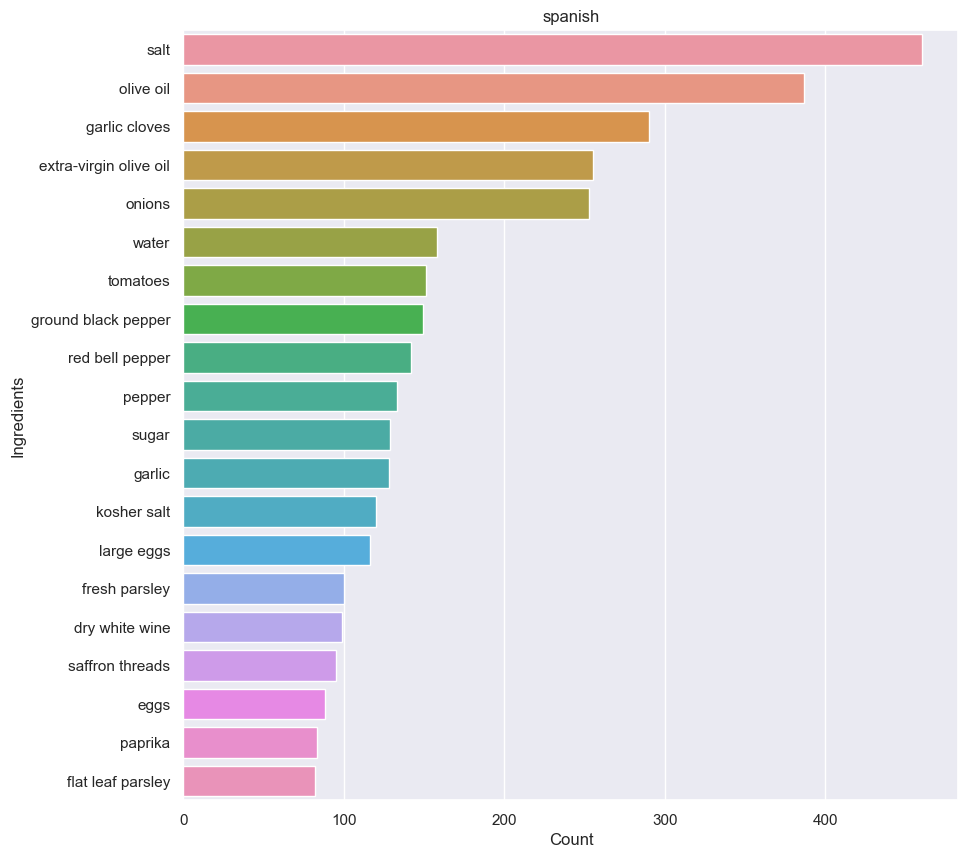

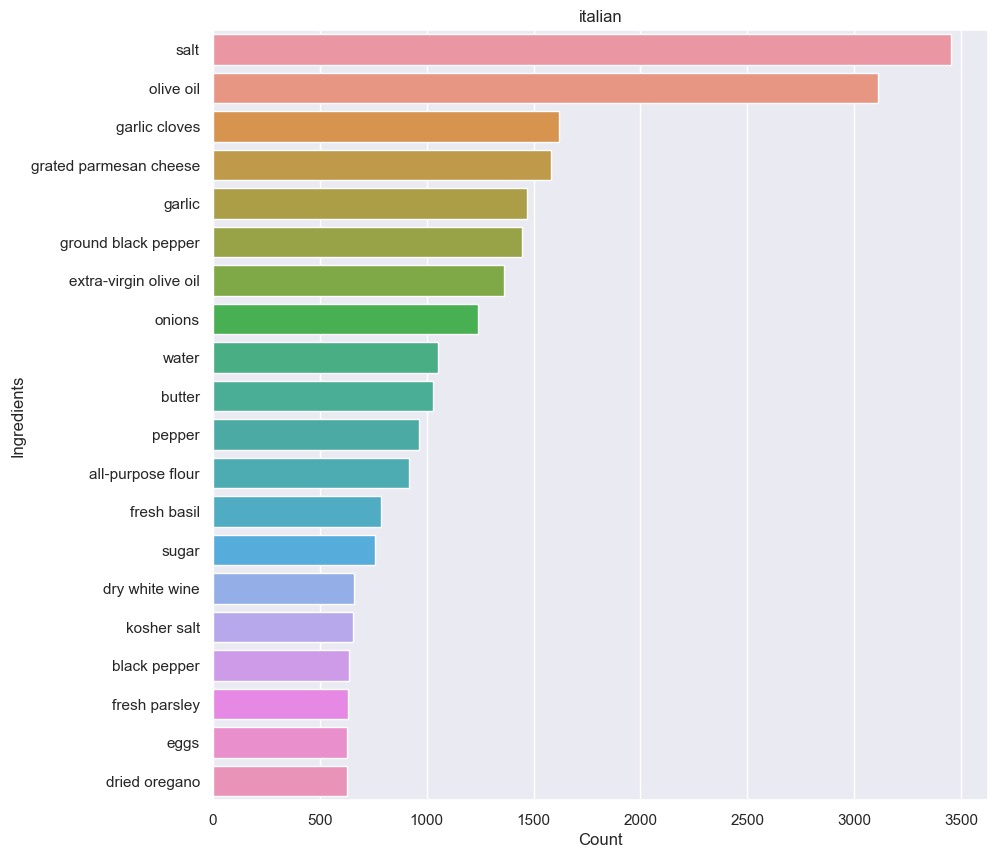

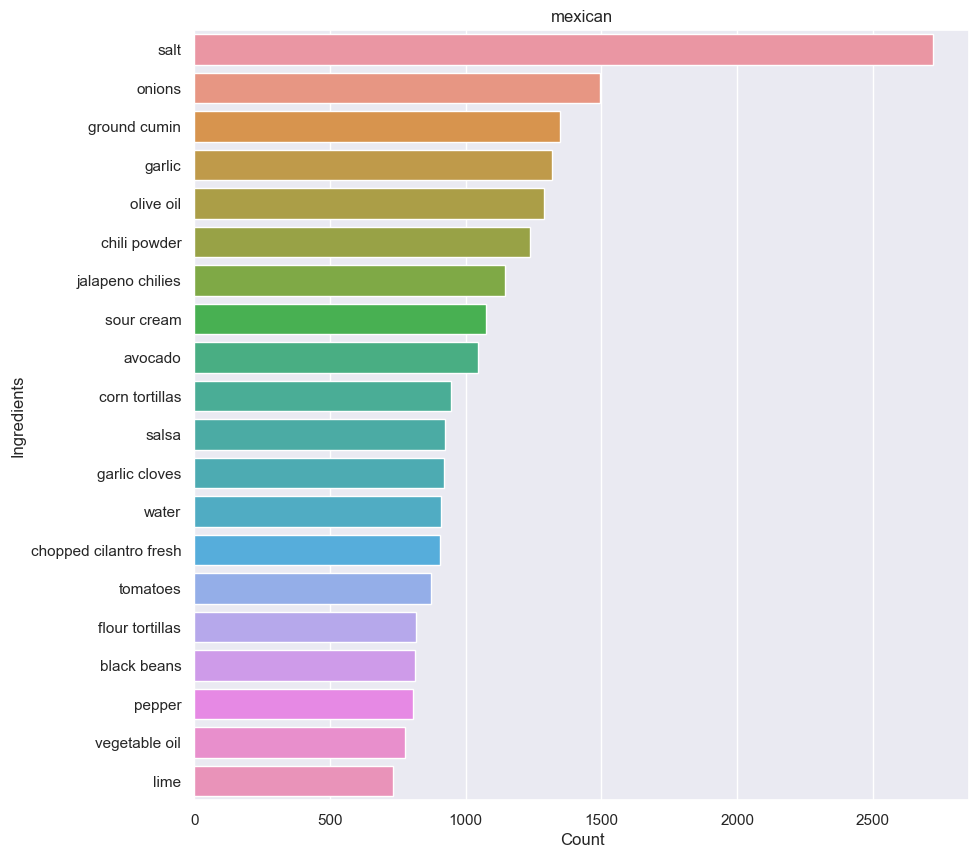

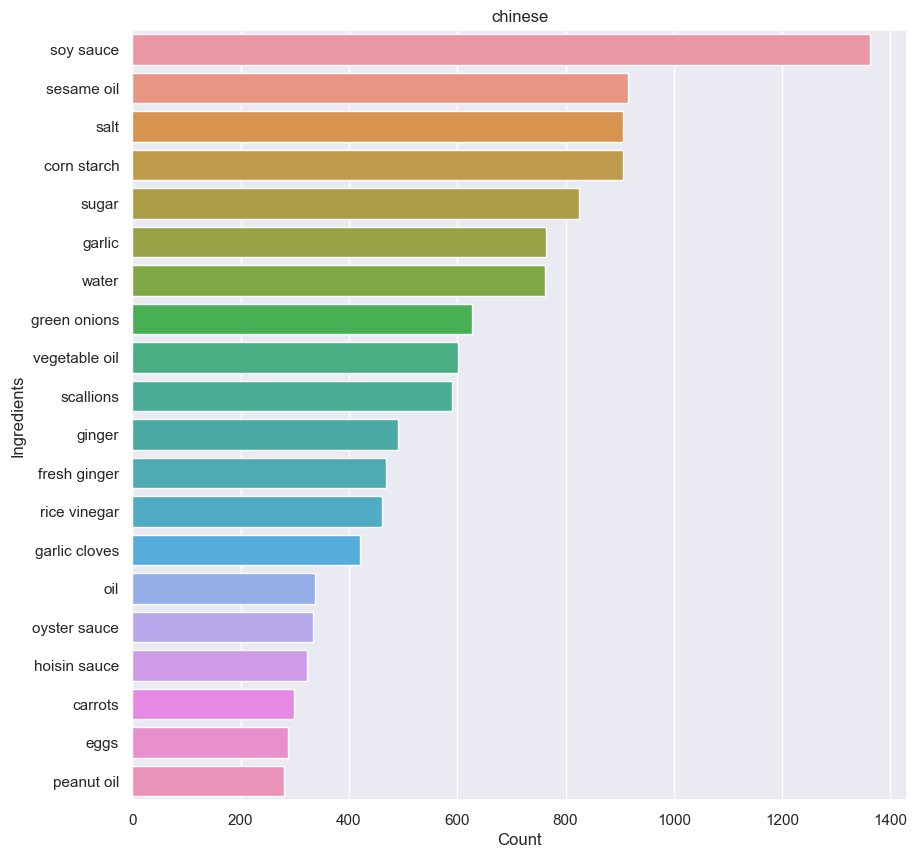

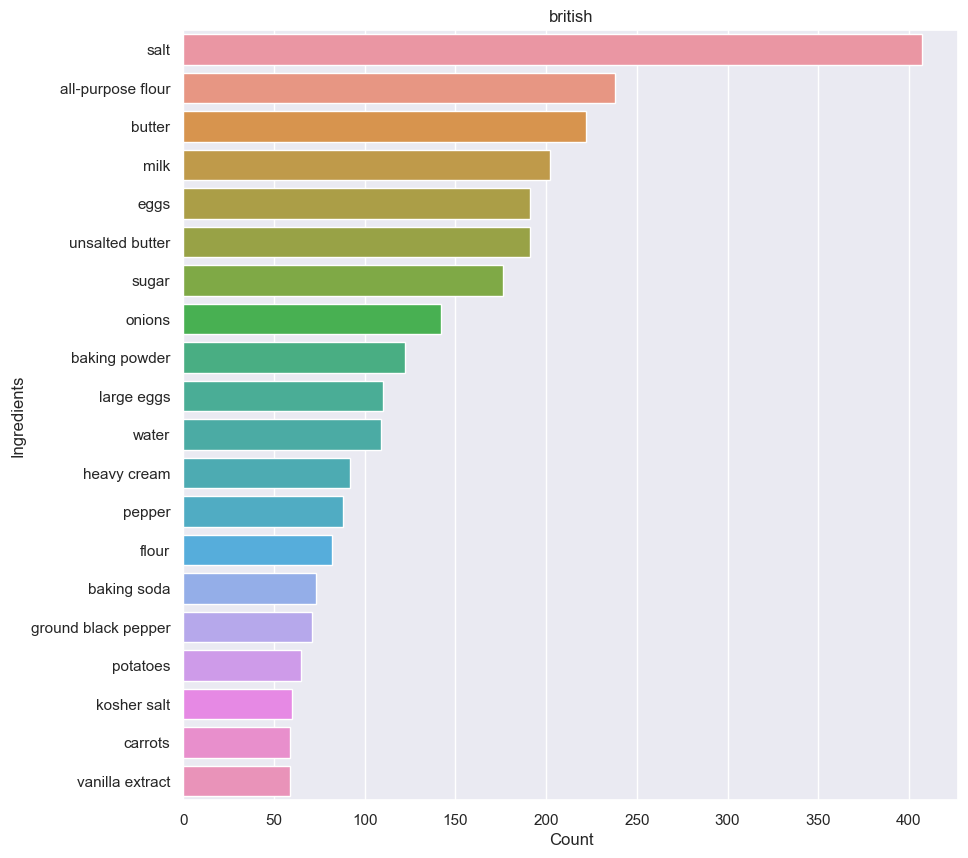

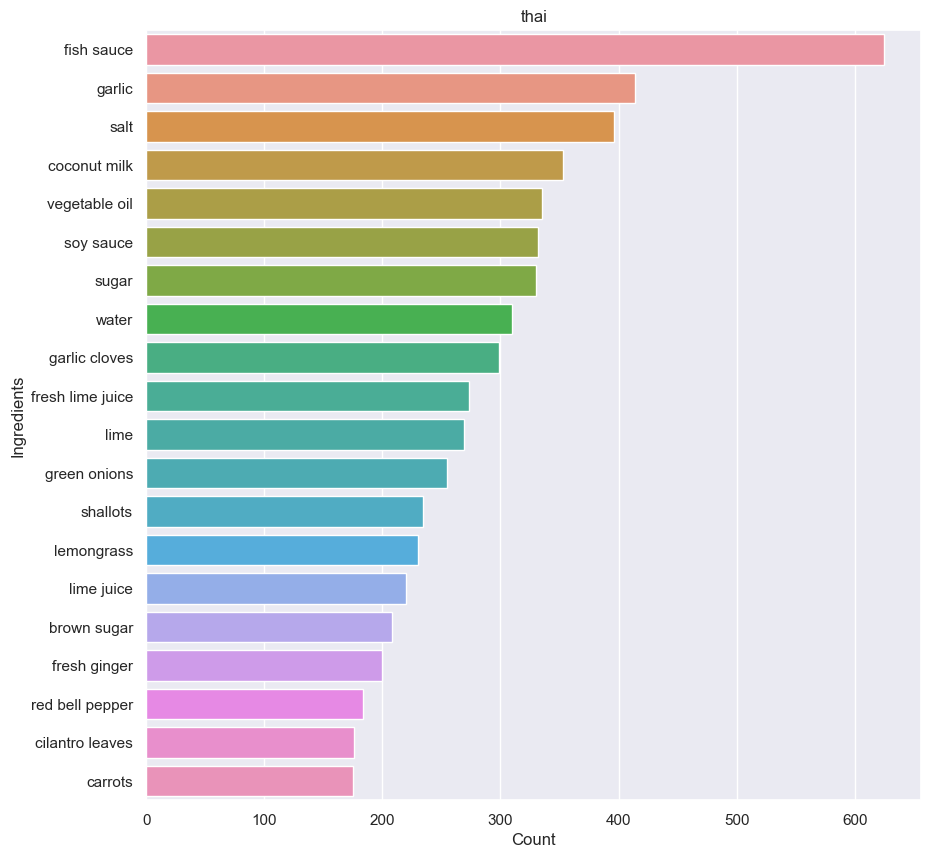

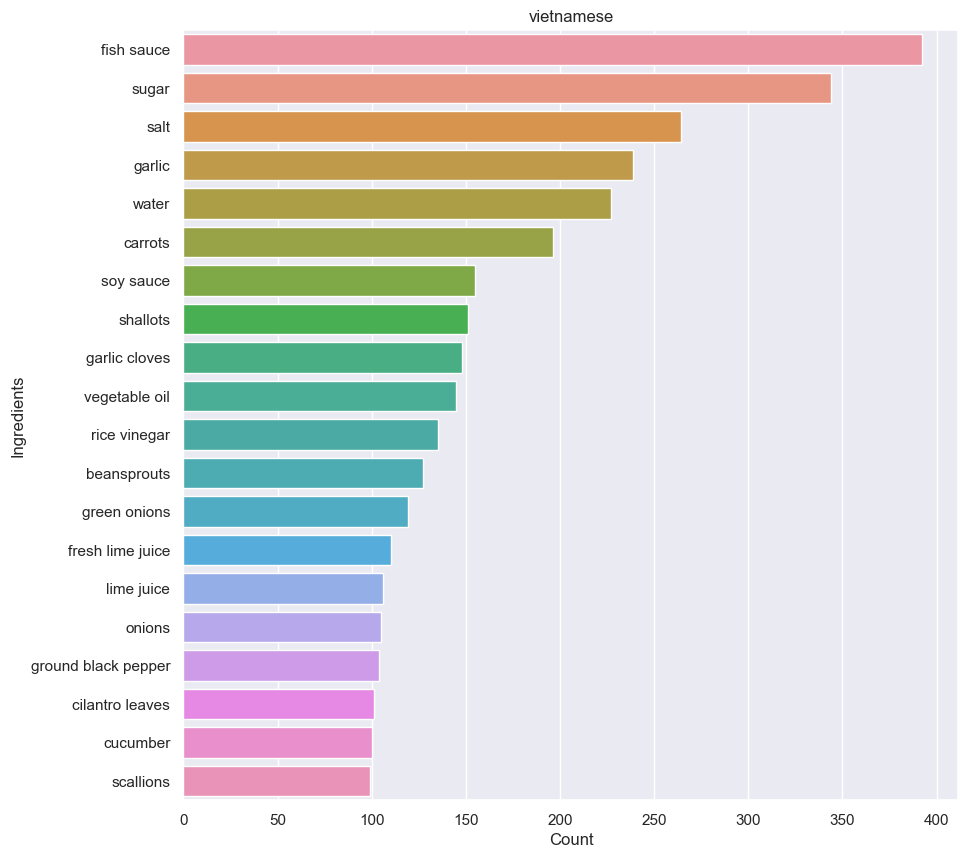

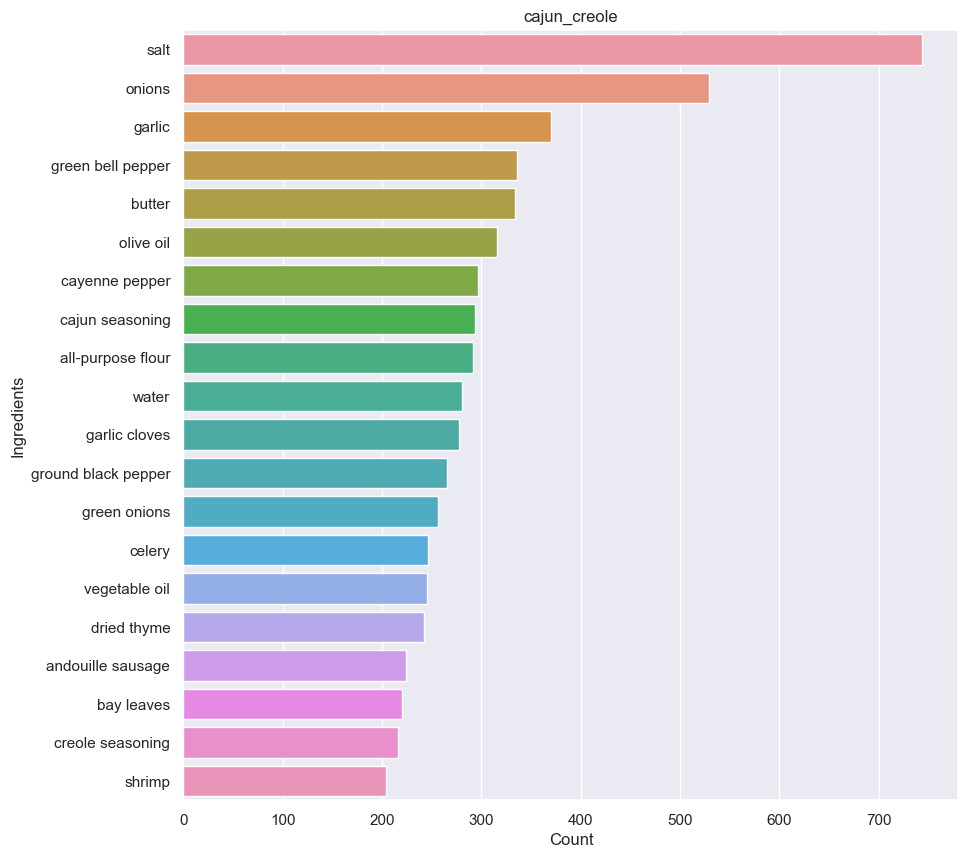

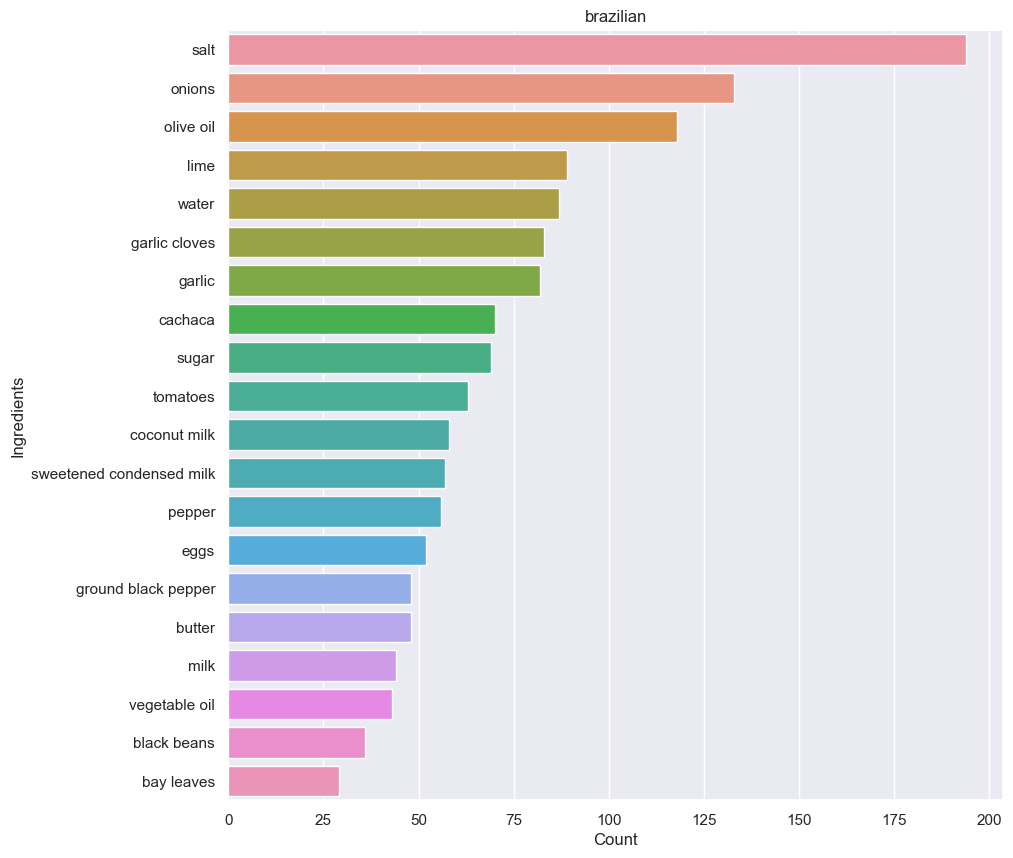

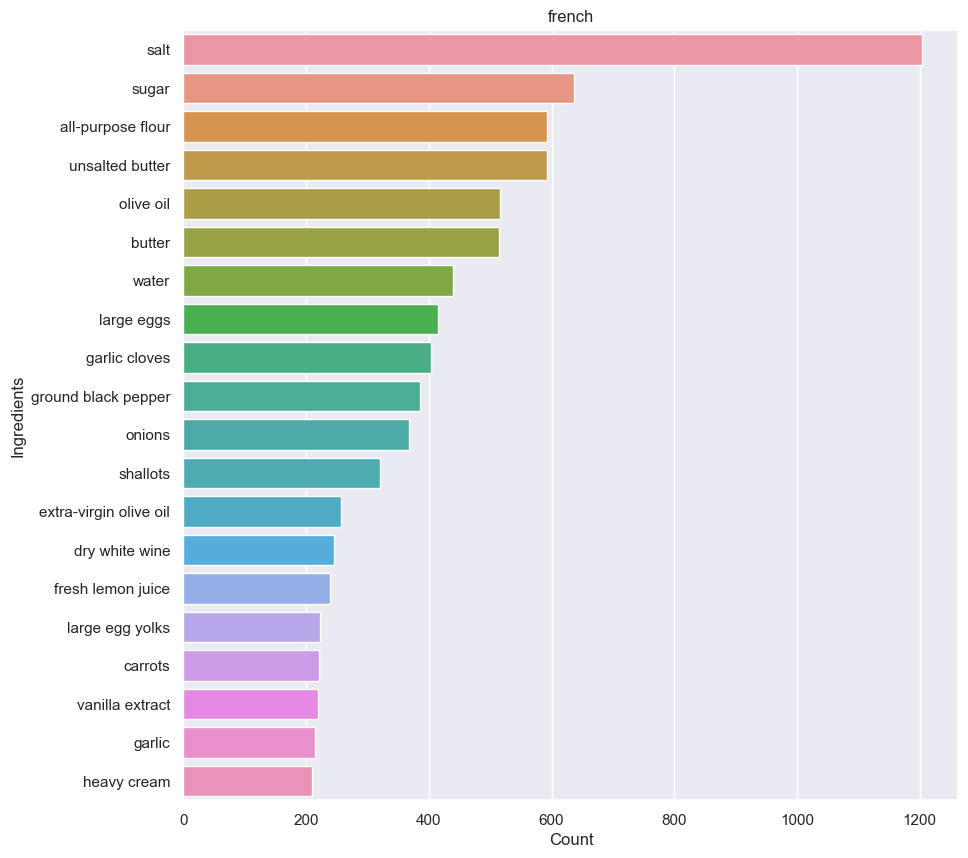

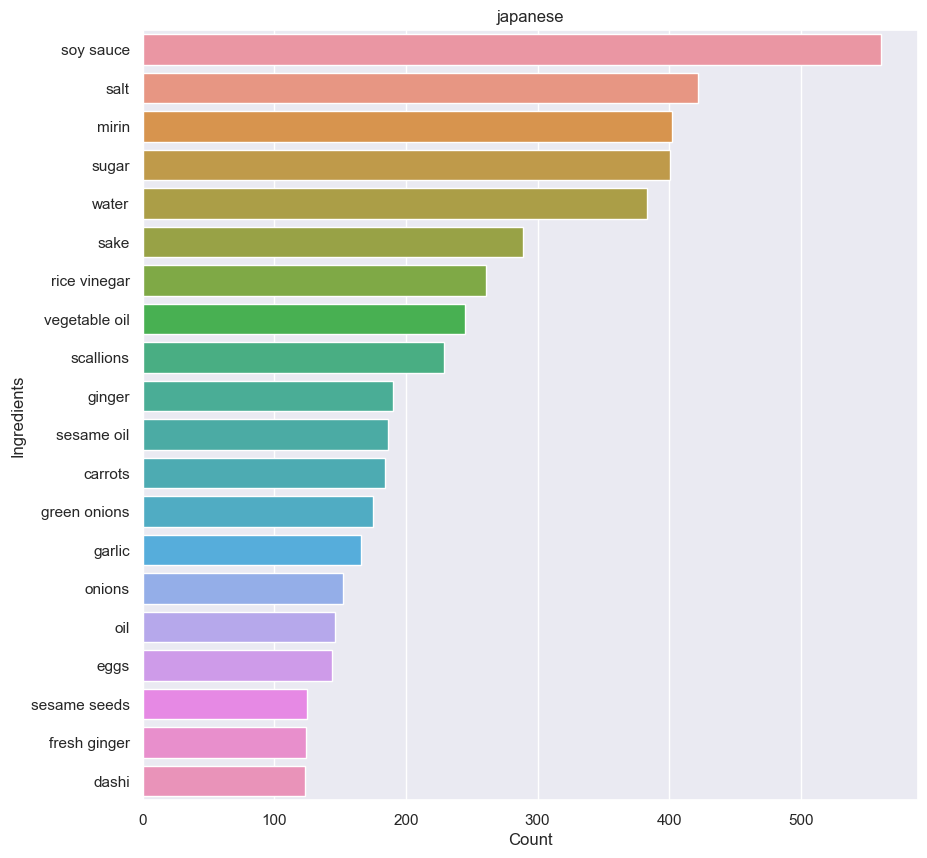

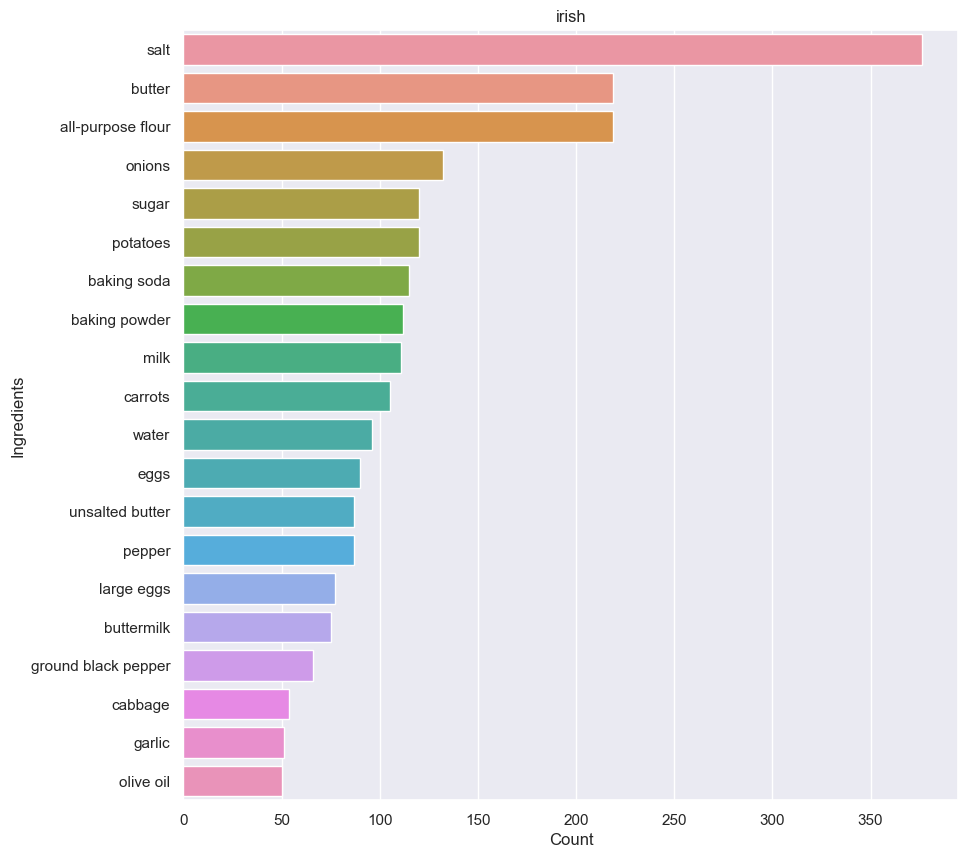

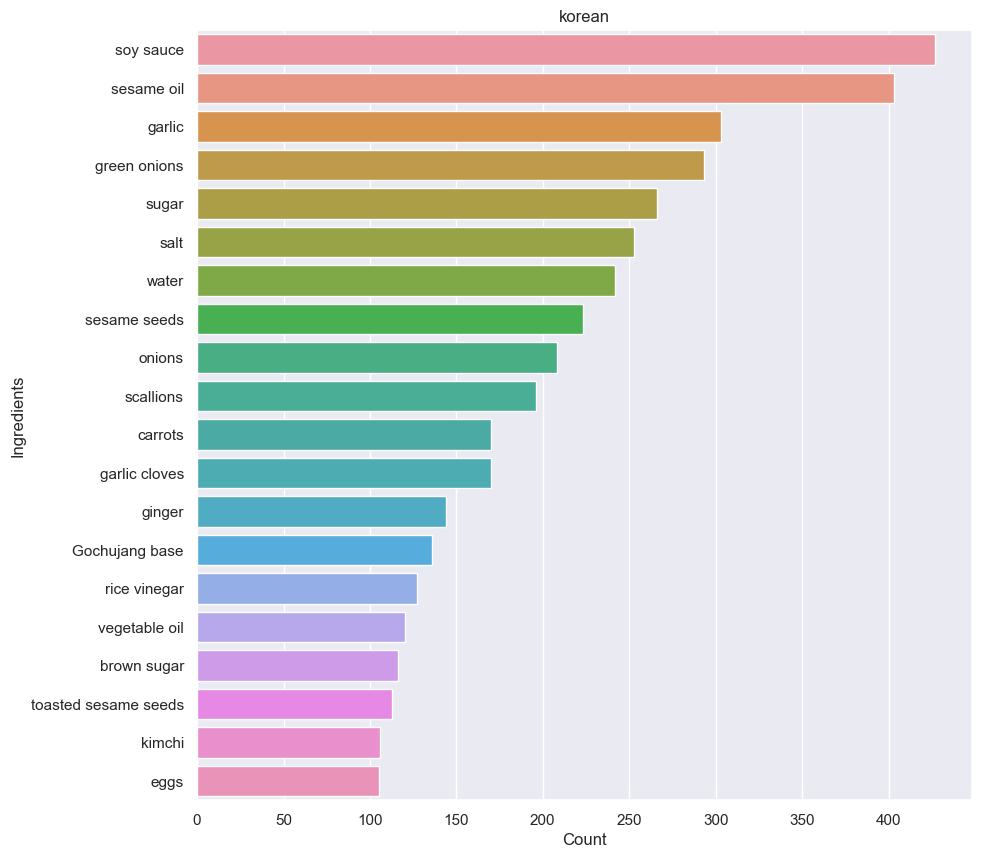

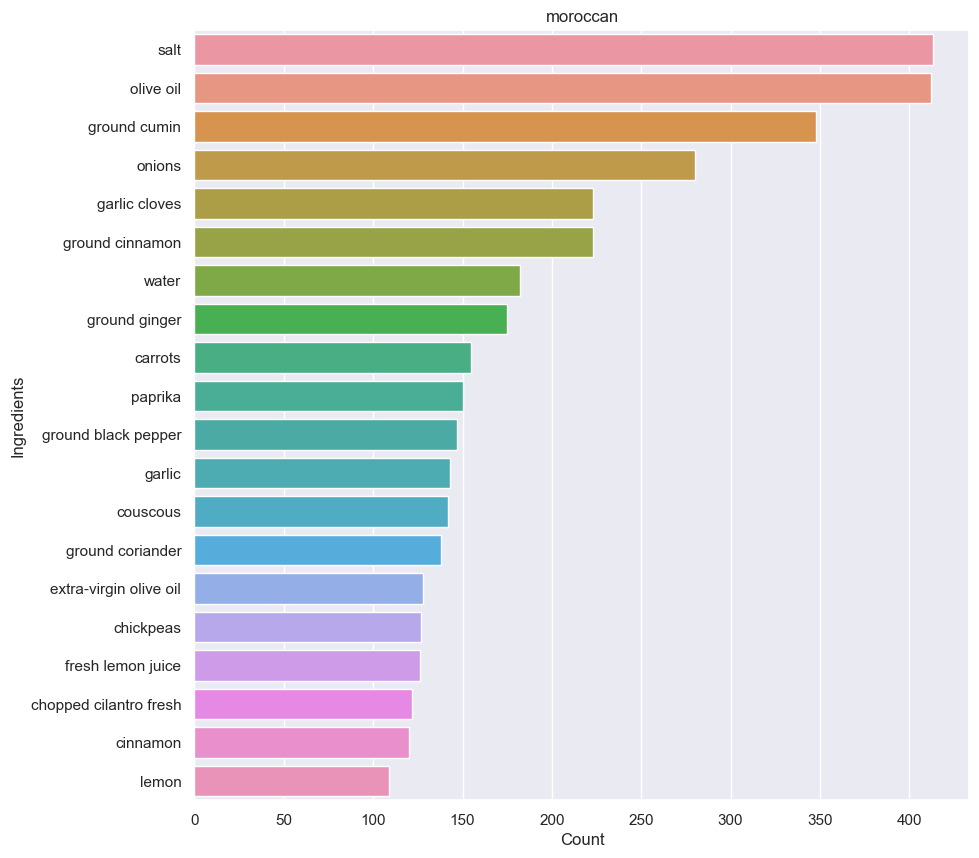

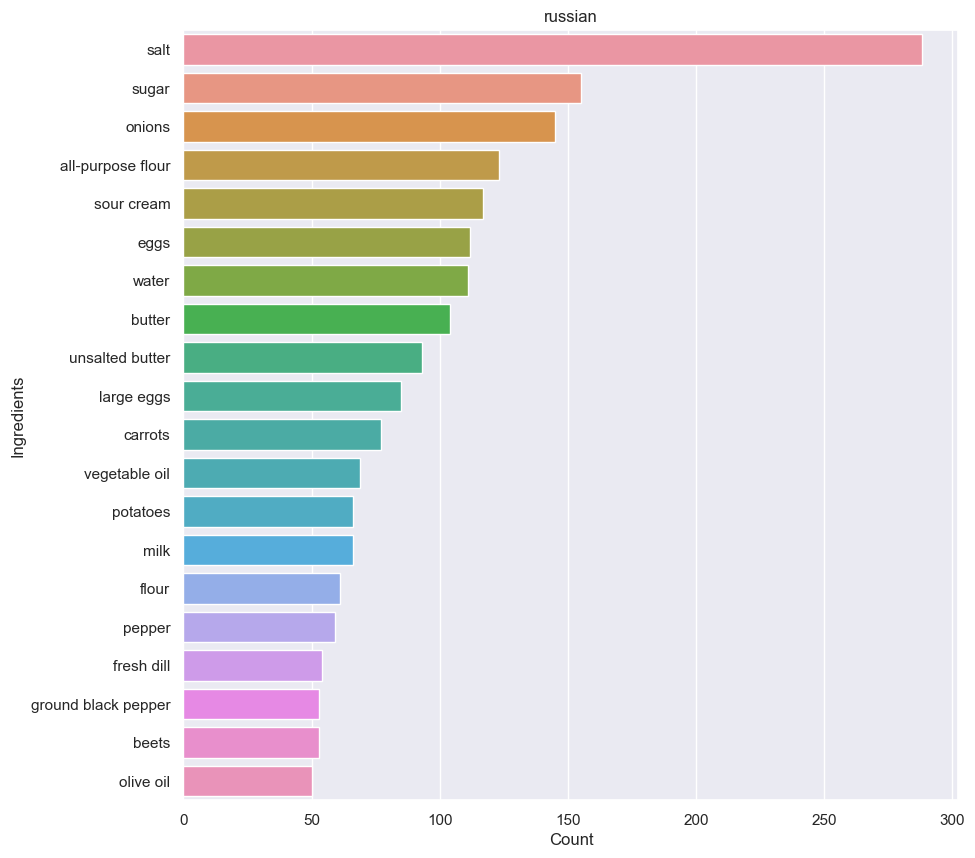

In [12]:
#Top 20 ingredients in all cuisines
cuisines = cookingData['cuisine'].unique()
for i in cuisines:
  ingredients=[]
  for j in cookingData[cookingData['cuisine']==i]['ingredients']:
    for k in j:
      ingredients.append(k)
  ingredients = pd.Series(ingredients)
  c_ingredients = ingredients.value_counts(sort=True).head(20)
  plt.figure(figsize=(10,10))
  sb.barplot(y = c_ingredients.index, x = c_ingredients.values)
  plt.title(i)
  plt.ylabel('Ingredients', fontsize=12)
  plt.xlabel('Count', fontsize=12)
  plt.show()

### Step 3 : Machine Learning

In [13]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import re

# Apply preprocess to the 'ingredients' column
def preprocess(ingredients):
    # Converting to lowercase
    ingredients = [x.lower() for x in ingredients]

    # Removing extra white spaces
    ingredients = [re.sub('\s+', ' ', x).strip() for x in ingredients]

    # Removing numbers
    ingredients = [re.sub("\d+", "", x) for x in ingredients]

    # Removing punctuation and special characters
    ingredients = [x.replace("-", " ").replace("&", " ").replace("'", " ").replace("''", " ").replace("%", " ").replace("!", " ").replace("(", " ").replace(")", " ").replace("/", " ").replace(",", " ").replace(".", " ") for x in ingredients]
    ingredients = [re.sub(r'[^\w\s]', '', x) for x in ingredients]

    # Removing units of measurement
    units_list = ['g', 'lb', 's', 'n', 'oz']
    ingredients = [remove_units(x, units_list) for x in ingredients]

    # Removing words which are not ingredients
    ingredients = [re.sub(r'crushed|crumbles|ground|minced|powder|chopped|sliced', '', x) for x in ingredients]

    return ' '.join(ingredients)

# Function to remove units from a string
def remove_units(word, units_list):
    s = word.split()
    resw = [word for word in s if word.lower() not in units_list]
    return ' '.join(resw)

# Create labels for recipes based on compatibility with dietary restrictions
def assign_labels(row):
    labels = []

    # Check for various seafood ingredients
    seafood_types = ['shrimp', 'lobster', 'fish', 'crab', 'clam', 'mussel', 'oyster', 'scallop', 'squid', 'octopus']

    if any(('milk' in ingredient or 'cheese' in ingredient or 'butter' in ingredient or 'yogurt' in ingredient or 'cream' in ingredient) for ingredient in row['ingredients'].split()):
        labels.append('Dairy Allergy')
    if any('eggs' in ingredient or 'egg' in ingredient for ingredient in row['ingredients'].split()):
        labels.append('Egg Allergies')
    if any('peanut' in ingredient or 'peanuts' in ingredient for ingredient in row['ingredients'].split()):
        labels.append('Peanut Allergies')
    if any(s in row['ingredients'] for s in seafood_types):
        labels.append('Seafood Allergies')
    return labels

# Assign labels to recipes based on their ingredients
cookingData['ingredients'] = cookingData['ingredients'].apply(preprocess)
cookingData['labels'] = cookingData.apply(assign_labels, axis=1)

# Convert labels to binary format (binary matrix where each column: dietary restriction, row: represents recipes with 1/0 to indicate restriction apply or not)
mlb = MultiLabelBinarizer()
label_matrix = mlb.fit_transform(cookingData['labels'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(cookingData['ingredients'], label_matrix, test_size=0.3, random_state=42)

# Feature extraction using TF-IDF vectorization - transform text data into numerical format suitable for machine learning
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train a Random Forest classifier - predict dietary restrictions based on the ingredients in the recipes
clf = RandomForestClassifier(n_estimators=100, random_state=42)  # Adjust max_depth as needed
clf.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = clf.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate F1 scores for each dietary restriction
f1_scores = []
dietary_restrictions = ['Dairy Allergy', 'Egg Allergies', 'Peanut Allergies', 'Seafood Allergies']

for i in range(y_test.shape[1]):
    f1 = f1_score(y_test[:, i], y_pred[:, i], average='binary')
    f1_scores.append(f1)

# Now you have F1 scores for each dietary restriction
for i, restriction in enumerate(dietary_restrictions):
    print(f"F1 Score for {restriction}: {f1_scores[i]}")


Accuracy: 0.9400821251990279
F1 Score for Dairy Allergy: 0.9907444668008049
F1 Score for Egg Allergies: 0.9702403662724151
F1 Score for Peanut Allergies: 0.7994579945799457
F1 Score for Seafood Allergies: 0.8733333333333333


In [14]:
cookingData

,id,cuisine,ingredients,labels
0,10259,greek,romaine lettuce black olives grape tomatoes ga...,[Dairy Allergy]
1,25693,southern_us,plain flour pepper salt tomatoes black peppe...,"[Dairy Allergy, Egg Allergies]"
2,20130,filipino,eggs pepper salt mayonaise cooking oil green c...,"[Dairy Allergy, Egg Allergies]"
3,22213,indian,water vegetable oil wheat salt,[]
4,13162,indian,black pepper shallots cornflour cayenne pepper...,[Dairy Allergy]
...,...,...,...,...
39769,29109,irish,light brown sugar granulated sugar butter warm...,"[Dairy Allergy, Egg Allergies]"
39770,11462,italian,kraft zesty italian dressing purple onion broc...,[Dairy Allergy]
39771,2238,irish,eggs citrus fruit raisins sourdough starter fl...,"[Dairy Allergy, Egg Allergies]"
39772,41882,chinese,boneless chicken skinless thigh garlic steame...,"[Egg Allergies, Peanut Allergies]"


In [15]:
from ipywidgets import interact, widgets

# Check unique classes present in the data
all_labels = [label for sublist in cookingData['labels'] for label in sublist]
unique_labels = set(all_labels)

# Define dietary restrictions and their labels
dietary_restrictions = ['Dairy Allergy', 'Egg Allergies', 'Peanut Allergies', 'Seafood Allergies']

# Ensure all dietary restrictions are known classes
for restriction in dietary_restrictions:
    if restriction not in unique_labels:
        unique_labels.add(restriction)

# Convert labels to binary format (binary matrix where each column: dietary restriction, row: represents recipes with 1/0 to indicate restriction apply or not)
mlb = MultiLabelBinarizer(classes=sorted(unique_labels))
label_matrix = mlb.fit_transform(cookingData['labels'])

def recommend_cuisines(selected_restriction):
    user_preferences = [selected_restriction]
    user_label = mlb.transform([user_preferences])
    cuisine_scores = []
    recommended_cuisines = set()
    top_recommendations = []

    for cuisine, prediction in zip(cookingData['cuisine'], y_pred):
        # Calculate compatibility by comparing the user's restriction to the predicted restriction
        score = sum(user_label[0] & prediction)
        cuisine_scores.append((cuisine, score))

    cuisine_scores.sort(key=lambda x: x[1], reverse=True)
    for cuisine, score in cuisine_scores:
        if cuisine not in recommended_cuisines:
            recommended_cuisines.add(cuisine)
            top_recommendations.append((cuisine, score))

    print("Top recommended cuisines:")
    for i, (cuisine, score) in enumerate(top_recommendations[:3]):
        print(f"{i+1}. {cuisine}")

# Create a dropdown widget for selecting dietary restrictions
restriction_dropdown = widgets.Dropdown(
    options=dietary_restrictions,
    description="Dietary Restriction:",
    style={'description_width': 'initial', 'width': 'auto'},  # Adjust the width as needed
)

# Create an interactive widget
interact(recommend_cuisines, selected_restriction=restriction_dropdown)

interactive(children=(Dropdown(description='Dietary Restriction:', options=('Dairy Allergy', 'Egg Allergies', …

<function __main__.recommend_cuisines(selected_restriction)>

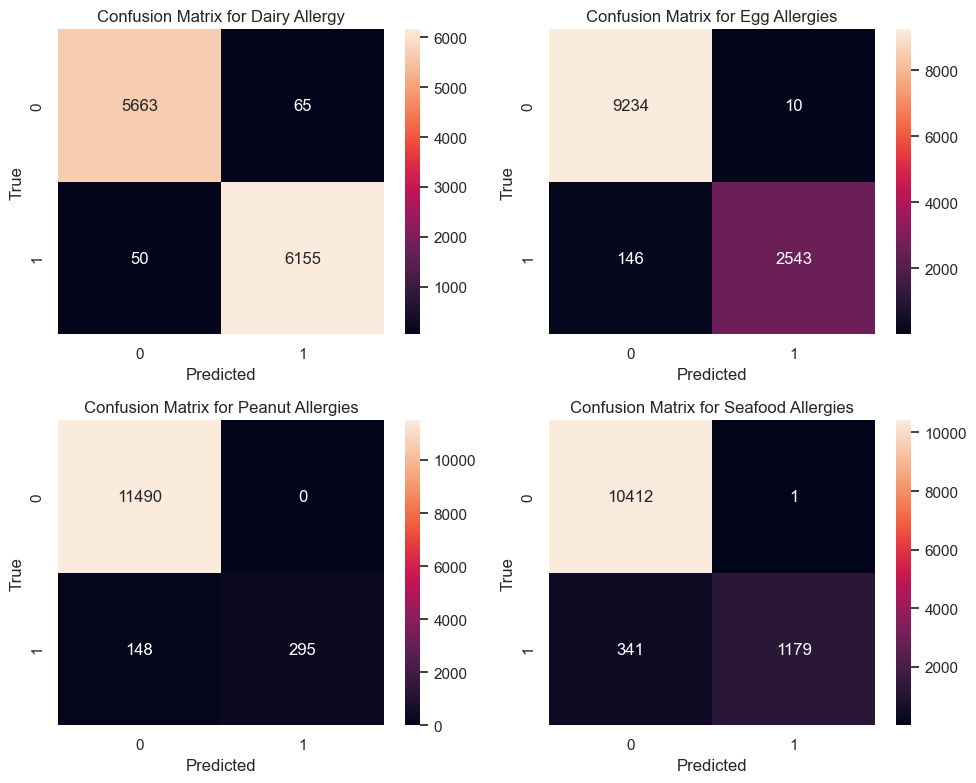

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

# Compute the multilabel confusion matrix
multilabel_cm = multilabel_confusion_matrix(y_test, y_pred)

# Display the confusion matrix for each label with a heatmap
# Create a 2x2 grid for confusion matrix heatmaps
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # Adjust the figure size as needed

for i, restriction in enumerate(dietary_restrictions):
    row = i // 2
    col = i % 2
    
    cm = multilabel_cm[i]
    classes = [0, 1]  # Define classes for binary classification, adjust if needed

    sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, ax=axes[row, col])
    axes[row, col].set_title(f"Confusion Matrix for {restriction}")
    axes[row, col].set_xlabel('Predicted')
    axes[row, col].set_ylabel('True')

plt.tight_layout()
plt.show()
